In [25]:
#Make a pretty pyramid with the imported modules :-)
import csv
%matplotlib inline 
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.patches as mpatches
import scipy.spatial.distance as scdist
from IPython.display import display, HTML
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
#from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
sb.set_style("whitegrid", {'axes.grid' : False})
import statsmodels.sandbox.stats.multicomp as mc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import silhouette_score, silhouette_samples

# Read and format data

## Read vocabulary file

In [2]:
def read_vocab(vocab_file_name):
    '''Reads vocabulary file into a list'''
    return [w.strip() for w in open(vocab_file_name)]

## Read docword.txt into a document x word matrix

In [3]:
def read_docword(file_name):
    '''
    Reads docword txt file into a Document-Term Matrix (DTM)
    The full DTM will be too large to hold in memory if represented    as a dense matrix. Use Scipy sparse instead
    Matrix multiplication involving the sparse representation is rapid thanks to algorithms that avoid explicitly
    performing multiplications by 0 (nNMF or SVD for instance involve matrix multiplication)
    '''

    file_handle = open(file_name)
    reader = csv.reader(file_handle, delimiter=' ')
    D = int(next(reader)[0])
    W = int(next(reader)[0])
    N = int(next(reader)[0])

    #create numpy DTM (Document-Term Matrix)
    m = np.empty(shape=[D,W], dtype='int8')
    #instead of creating a sparse matrix and then fill it up, create a numpy matrix
    #and then later convert it to csr -> SparseEfficiencyWarning
    #m = sparse.csr_matrix( (D,W), dtype='int8')

    for row in reader:
        D_i = int(row[0])-1
        W_i = int(row[1])-1
        count = int(row[2])
        m[D_i, W_i] = count

    m = sparse.csr_matrix(m)

    return D,W,N,m

In [4]:
docword_file = 'data/docword.kos.txt'
D,W,N,DTM = read_docword(docword_file)

In [5]:
vocab_file = 'data/vocab.kos.txt'
vocab = read_vocab(vocab_file)

##  TF-IDF: term frequency inverse document frequency

TFIDF is a more reliable metric than plain frequency because it normalizes frequency across documents.  Very common (and semantically meaningless) words like articles ('the', 'a', 'an' ...), prepositions, etc... are in this way given less weight and filtered out 

In [6]:
tfidf_transformer = TfidfTransformer()
DTM_tfidf = tfidf_transformer.fit_transform(DTM)

# Document Clustering and Topic Modeling

Now comes the interesting part  

This is an unsupervised document clustering / topic extraction.
We have no previous knowledge on the number of topics there are in every corpus of documents.  

A conventional approach involves an -optional- initial step of LSA (Latent Semantic Analysis) (TruncatedSVD) for dimensionalty reduction followed by K-Means.  The downside to this approach in this scenario is that it requires a predefined number of clusters, which is not available

There might not be an optimal number of clusters with complete separation, but there are ways to assess/approximate it.
The 'elbow' method consists of plotting a range of number of clusters on the x axis and the average within-cluster sum of squares in the y axis (as a measure of within cluster similarity between its elements). Then an inflexion point would be
indicative of a good k  

Another option to estimate an initial number of clusters consists of running a hierachical clustering and plot a dendrogram. Depending on the method and metric different results can be achieved.   

If a good candidate for k is found K-Means can be re-run using it as input. In addition, several K-Means runs are advised since the algorithm might end up in a local optima.   

Another approach would be to use a different clustering algorithm not requiring a predefined number of clusters:
Means-shift, for instance . But this has not provided good results in this scenario (1 or 2 big groups)

## SVD/LSA  

TruncatedSVD implements a variant of singular value decomposition (SVD) that only computes the k largest singular values, 
where k is a user-specified parameter.  

When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as latent semantic analysis (LSA), because it transforms such matrices to a “semantic” space of low dimensionality.   

In particular, LSA is known to combat the effects of synonymy and polysemy (both of which roughly mean there are multiple meanings per word), which cause term-document matrices to be overly sparse and exhibit poor similarity under measures such as cosine similarity.  

TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.  

The appropriate value of s is a matter of debate, and is application-dependent. Smaller values of s represent a greater extent of dimensionality reduction at the cost of a loss of structure of the original DTM. Values anywhere from 30 to 300 are commonly used.   
In practice, using a cumulative scree plot to select s so that roughly 75–80% of the original variance is recovered tends to strike a good balance

In [7]:
#kos W/5 -> 83%
n_components = W/5

svd = TruncatedSVD(n_components)
# DTM_tfidf results are normalized. Since LSA/SVD results are
# not normalized, we have to redo the normalization:
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

%time \
DTM_tfidf_lsa = lsa.fit_transform(DTM_tfidf)

print("Explained variance of the SVD step: {}%".format(int(svd.explained_variance_ratio_.sum() * 100)))

CPU times: user 32.2 s, sys: 13.9 s, total: 46.1 s
Wall time: 10.4 s
Explained variance of the SVD step: 83%


For the kos dataset, LSA (n_components = W/5 explaining 83% of the original variance)  
reduces the size of the DTM from shape (3430, 6906) to (3430, 1381)

## K-Means

K-Means separates samples in n groups of equal variance  
first step chooses the initial centroids (k, the number of clusters)  
After initialization, K-means consists of looping between the two other steps:  
The first step assigns each sample to its nearest centroid.  
The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid
The inertia or within-cluster sum-of-squares is minimized

### Try to find  optimal number of clusters for k-means. "Elbow" method

Run this 'elbow' plot on the LSA reduced DTM_tfidf for the smaller datasets: kos and nips  
Run it on the super-reduced irlb DTM_tfidf for the larger datasets enron nytimes and pubmed

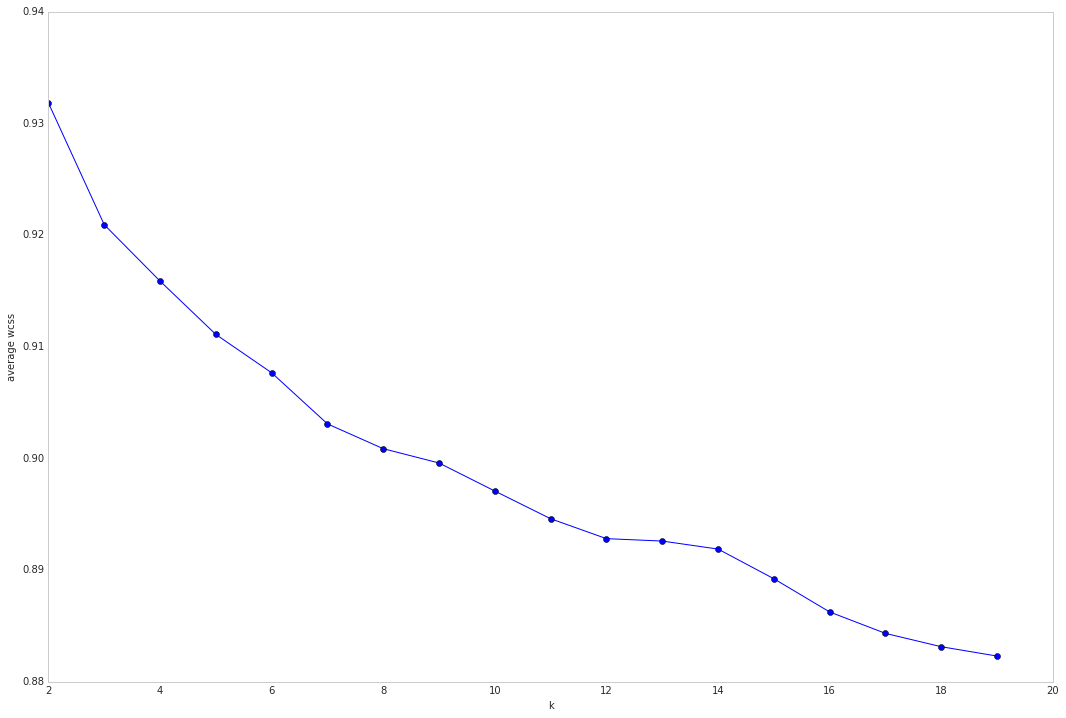

In [13]:
k_range = range(2,20)
kms = [KMeans(n_clusters=k, init='k-means++').fit(DTM_tfidf_lsa) for k in k_range]
centroids = [X.cluster_centers_ for X in kms]
labels = [km.labels_ for km in kms]
#calculate Euclidean distance from each point to cluster center
k_euclid = [scdist.cdist(DTM_tfidf_lsa, c, 'euclidean') for c in centroids] 
dist = [np.min(ke, axis=1) for ke in k_euclid]
#Total within cluster sum of squares
wcss = [sum(d**2) for d in dist]
#average wcss
avwcss = [(sum(d**2))/len(d) for d in dist]
#total sum of squares
tss = sum(scdist.pdist(DTM_tfidf_lsa)**2)/DTM_tfidf_lsa.shape[0]
#between cluster sum of squares:
bss = tss - wcss
#plot average wcss vs number of clusters "Elbow plot": look for a point where the rate of decrease in wcss sharply shifts
plt.subplots(figsize=(18, 12)) # set size
plt.plot(k_range, avwcss, '-o')
plt.ylabel("average wcss")
plt.xlabel("k")

### Not very clear elbow? Check out the Silhouette scores

In [14]:
silhouette_avg_scores = [silhouette_score(docword_tfidf, l) for l in labels]
print silhouette_avg_scores

[0.019074356579233953, 0.023240564880013723, 0.024028296812336956, 0.025919575579062177, 0.026861760217288647, 0.013321506889758637, 0.013536290635032448, 0.01451164797130685, 0.014830797754892374, 0.013388411008660303, 0.012483410542328629, 0.015275226554560749, 0.027228038459763966, 0.012797013871169995, 0.013817068993089826, 0.014762985936250679, 0.01653236589461024, 0.014915275197301334]


## Initialize KMeans object

In [8]:
k = 8
#these are all default options (except for k)
km = KMeans(algorithm='auto',
            copy_x=True,
            init='k-means++',
            max_iter=300,
            n_clusters=k,
            n_init=10,
            n_jobs=1,
            precompute_distances='auto',
            random_state=None,
            tol=0.0001,
            verbose=0)

## Compute KMeans on the TFIDF matrix

In [9]:
%time km.fit(DTM_tfidf_lsa)

CPU times: user 5.71 s, sys: 3.33 s, total: 9.04 s
Wall time: 4.37 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Sort cluster centers by proximity to centroid

In [10]:
clusters = km.labels_
k_centers = km.cluster_centers_ #Coordinates of cluster centers  [n_clusters, n_features]
original_space_centroids = svd.inverse_transform(k_centers)
order_centroids = original_space_centroids.argsort()[:, ::-1] #argsort returns the indices that would sort an array

#### Print Cluster index and n words (closest to centroid) associated

In [11]:
lsa_cluster_topics = {}
for c in range(k):
    topic = ','.join([vocab[i] for i in [ix for ix in order_centroids[c, :5]]])
    lsa_cluster_topics[c] = topic
    print "Cluster %i: " % c + topic

Cluster 0: iraq,war,bush,iraqi,military
Cluster 1: dean,clark,edwards,kerry,lieberman
Cluster 2: party,nader,democratic,ballot,state
Cluster 3: bush,administration,president,kerry,general
Cluster 4: november,account,electoral,turnout,governor
Cluster 5: kerry,bush,poll,percent,voters
Cluster 6: november,voting,account,electoral,governor
Cluster 7: house,senate,race,elections,district


This takes forever without dim red. Use DTM_tfidf_lsa instead of DTM_tfidf
Note also that DTM_tfdif_lsa, unlike DTM_tfidf, is not sparse anymore. No need to convert to dense format!

Silhouette Coefficients range between [-1,1]. Values near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.  
These values are not good, but this measure seems to suffer from the phenomenon called “Concentration of Measure” or “Curse of Dimensionality"   
Check http://scikit-learn.org/stable/auto_examples/text/document_clustering.html  

## Term enrichment analysis

In [23]:
def enrich(document_term_matrix, doc_idxs, n_terms_in_corpus):
    '''
    uses scipy.stats hypergeometric test to extract probabilities (p-values) of term enrichment in a group of documents
    groups can be defined for instance from the K-Means analysis
    uses absolute count frequencies not tfidf (tfidf are already document-normalized)
    '''
    DTM = document_term_matrix
    enrichment = pd.DataFrame(columns=["word", "word_count_in_cluster", "n_words_in_cluster", "word_count_in_corpus", "n_words_in_corpus", "p-val" ])
    word_idx = DTM[doc_idxs].nonzero()[1]
    word_idx = np.unique(word_idx)
    for i in range(len(word_idx)):
        t = word_idx[i]
        n_terms_in_cluster = len(DTM[doc_idxs].nonzero()[1])
        term_count_in_cluster = DTM[doc_idxs,t].sum()
        term_count_in_corpus = DTM[:,t].sum()
        p = stats.hypergeom.sf(term_count_in_cluster, n_terms_in_corpus, n_terms_in_cluster, term_count_in_corpus)
        enrichment.loc[i] = [vocab[t], term_count_in_cluster, n_terms_in_cluster, term_count_in_corpus, n_terms_in_corpus, p]
        #Multiple hypothesis correction, transform p-values to adjusted p-values:
    reject, adj_pvalues, corrected_a_sidak, corrected_a_bonf =  mc.multipletests(enrichment["p-val"], method='fdr_bh')
    enrichment["adj_pval(BH)"] = adj_pvalues
    enrichment = enrichment.sort_values(by='adj_pval(BH)').head(10)
    return enrichment

In [28]:
cl0_doc_idxs = [c[0] for c in enumerate(clusters) if c[1] == 0]
#Remember N is the total nonzero count values in corpus
#It can be estimated as well as: len(DTM.nonzero()[1])
cluster0_enrichment = enrich(DTM, cl0_doc_idxs, N)
HTML(cluster0_enrichment.to_html())

,word,word_count_in_cluster,n_words_in_cluster,word_count_in_corpus,n_words_in_corpus,p-val,adj_pval(BH)
3955,petraeus,23,59975,23,353160,0.0,0.0
2873,iraq,1574,59975,2217,353160,0.0,0.0
3032,kufa,12,59975,12,353160,0.0,0.0
3033,kurdish,20,59975,20,353160,0.0,0.0
4953,shrine,14,59975,14,353160,0.0,0.0
1375,dearborn,11,59975,11,353160,0.0,0.0
3173,lindauer,15,59975,15,353160,0.0,0.0
175,alhusainy,12,59975,12,353160,0.0,0.0
3279,maj,12,59975,12,353160,0.0,0.0
2334,gharib,10,59975,10,353160,0.0,0.0


In [29]:
cl1_doc_idxs = [c[0] for c in enumerate(clusters) if c[1] == 1]
cluster1_enrichment = enrich(DTM, cl1_doc_idxs, N)
HTML(cluster1_enrichment.to_html())

,word,word_count_in_cluster,n_words_in_cluster,word_count_in_corpus,n_words_in_corpus,p-val,adj_pval(BH)
2119,lieb,14,23087,14,353160,0.000000e+00,0.000000e+00
645,clark,625,23087,820,353160,0.000000e+00,0.000000e+00
942,dean,1278,23087,1798,353160,0.000000e+00,0.000000e+00
1193,edwards,681,23087,1127,353160,0.000000e+00,0.000000e+00
2120,lieberman,354,23087,459,353160,4.702023e-320,3.903619e-317
1589,gephardt,367,23087,530,353160,2.941865e-302,2.035280e-299
1935,iowa,351,23087,597,353160,8.080964e-252,4.792012e-249
2821,primary,520,23087,1528,353160,4.658350e-225,2.417102e-222
2015,kerry,886,23087,4679,353160,3.503594e-181,1.615935e-178
2038,kucinich,165,23087,214,353160,1.021201e-150,4.239004e-148


## Hierarchical clustering  

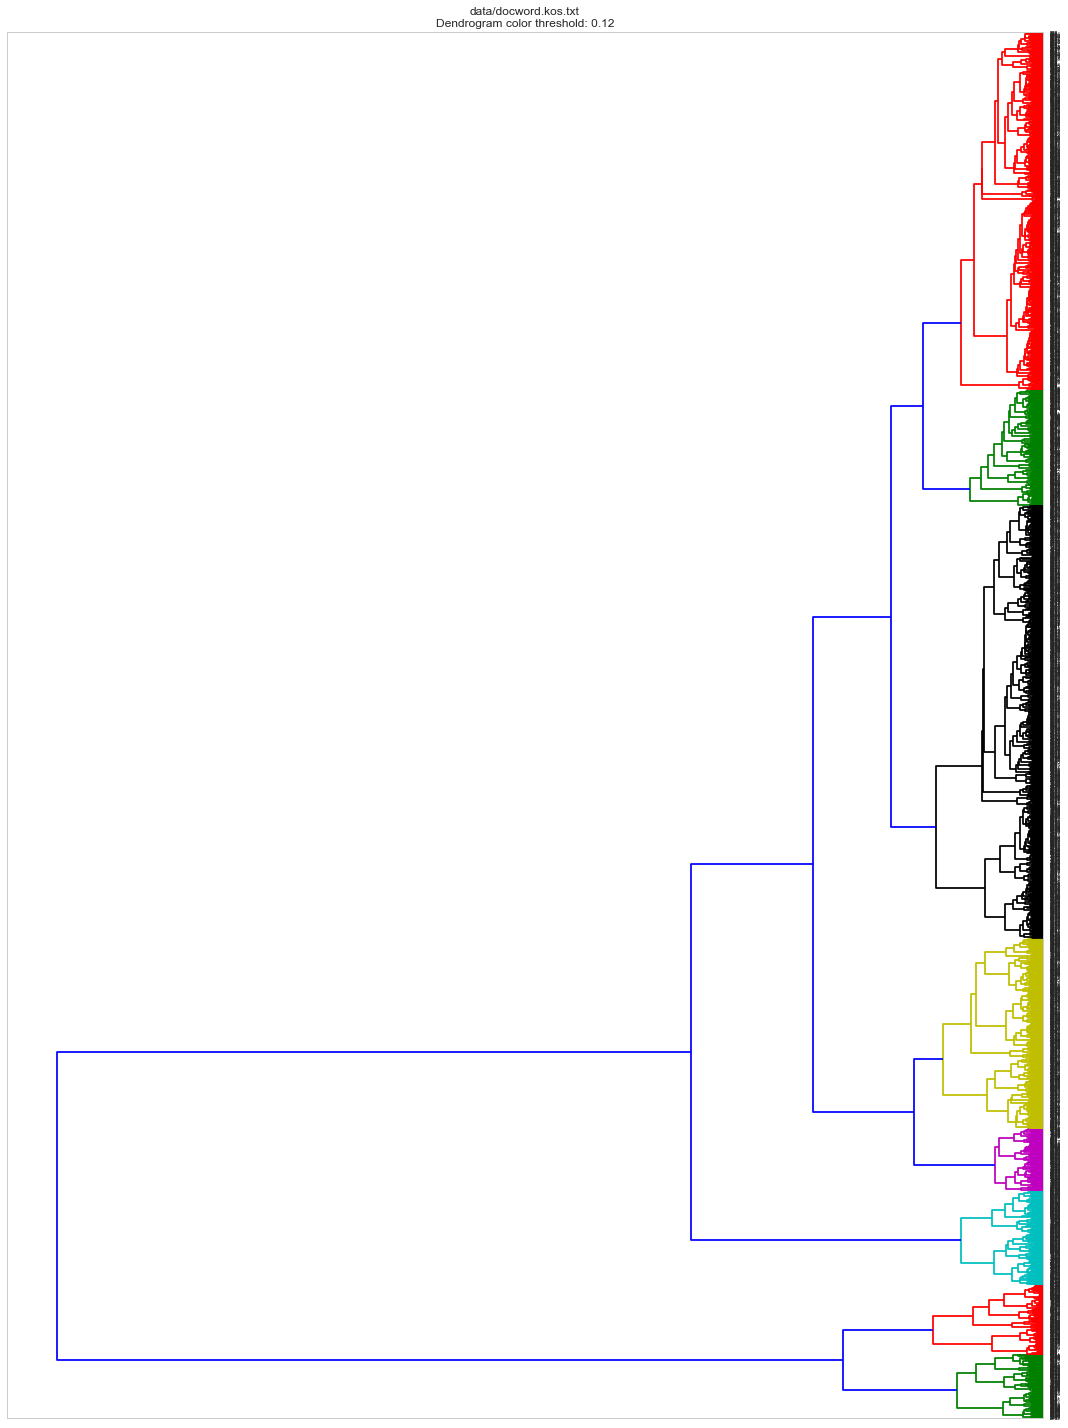

In [13]:
#sklearn.metrics.pairwise cosine_similarity
dist = 1 - cosine_similarity(DTM_tfidf_lsa)

#Then get linkage matrix
linkage_matrix_ward = sch.ward(dist) 

#And then plot the dendrogram
dendro_color_threshold = 0.12 #default: 0.7
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = sch.dendrogram(linkage_matrix_ward, orientation="left",color_threshold=dendro_color_threshold*max(linkage_matrix_ward[:,2]));
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.title(docword_file + "\n" + "Dendrogram color threshold: %s"%dendro_color_threshold)
plt.tight_layout() #show plot with tight layout
plt.show()

## Dimensionality Reduction and Plot

### TSNE
t-SNE is a machine learning technique for dimensionality reduction that helps you to identify relevant patterns.  The main advantage of t-SNE is the ability to preserve local structure. This means, roughly, that points which are close to one another in the high-dimensional data set will tend to be close to one another in the chart. t-SNE also produces beautiful looking visualizations.

In [14]:
tsne_cos = TSNE(n_components=2, 
                perplexity=30, 
                learning_rate=1000, 
                n_iter=1000, 
                metric='cosine', 
                verbose=1)

In [15]:
dist = 1 - cosine_similarity(DTM_tfidf_lsa)

tsne_cos_coords = tsne_cos.fit_transform(dist)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3430
[t-SNE] Computed conditional probabilities for sample 2000 / 3430
[t-SNE] Computed conditional probabilities for sample 3000 / 3430
[t-SNE] Computed conditional probabilities for sample 3430 / 3430
[t-SNE] Mean sigma: 0.008588
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.530214
[t-SNE] Error after 250 iterations: 1.530214


In [20]:
def scatter(x, labels, cluster_topics):
    n_labels = len(set(labels))
    palette = np.array(sb.color_palette("hls", n_labels )) # color palette with seaborn.
    f = plt.figure(figsize=(18, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], linewidth=0, s=40, color=palette[labels])
    #ax.axis('off')
    ax.axis('tight')
    txts = []
    color_patches = []
    for i in range(n_labels):
        # Position of each label
        patch = mpatches.Patch(color=palette[i], label= "Cluster %i "% i + " " + cluster_topics[i])
        color_patches.append(patch)
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=18)
        txts.append(txt)
    plt.legend(handles=color_patches, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=14)
    plt.subplots_adjust(right=0.60)
    plt.title(docword_file + "\n" + "k = %s" %len(set(km.labels_)), fontsize=16)
    plt.show()

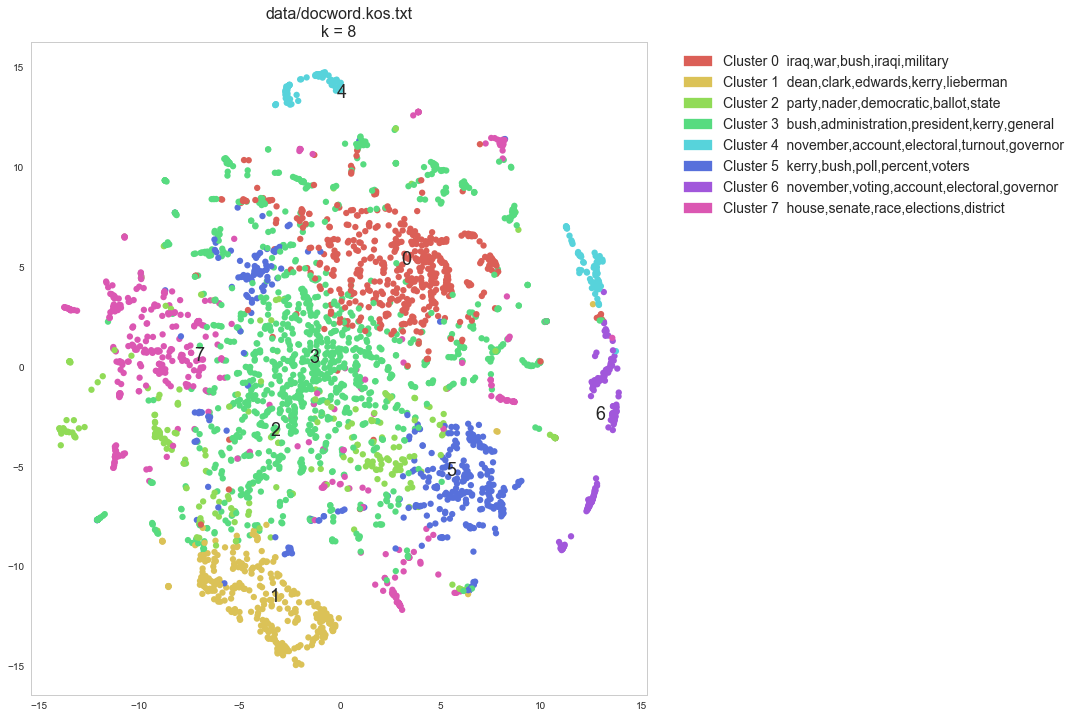

In [21]:
scatter(tsne_cos_coords, km.labels_, lsa_cluster_topics)